
### **Business Context**
Workplace safety in hazardous environments like construction sites and industrial plants is crucial to prevent accidents and injuries. One of the most important safety measures is ensuring workers wear safety helmets, which protect against head injuries from falling objects and machinery. Non-compliance with helmet regulations increases the risk of serious injuries or fatalities, making effective monitoring essential, especially in large-scale operations where manual oversight is prone to errors and inefficiency.

To overcome these challenges, SafeGuard Corp plans to develop an automated image analysis system to detect whether workers are wearing safety helmets. This system will improve safety enforcement, ensuring compliance and reducing the risk of head injuries. By automating helmet monitoring, SafeGuard aims to enhance efficiency, scalability, and accuracy, ultimately fostering a safer work environment while minimizing human error in safety oversight.

### **Objective**
As a data scientist at SafeGuard Corp, you are tasked with developing an image classification model that classifies images into one of two categories:
- **With Helmet**: Workers wearing safety helmets.
- **Without Helmet**: Workers not wearing safety helmets.

The ultimate objective is to prepare the model for deployment as part of an automated monitoring system. This system will enable real-time analysis of images and assist in ensuring compliance with workplace safety regulations.

### **Data Dictionary**
The dataset consists of 631 images, equally divided into two categories:

- With Helmet: 311 images showing workers wearing helmets.
- Without Helmet: 320 images showing workers not wearing helmets.

### **Dataset Characteristics**
- Variations in Conditions: Images include diverse environments such as construction sites, factories, and industrial settings, with variations in lighting, angles, and worker postures to simulate real-world conditions.
- Worker Activities: Workers are depicted in actions such as standing, using tools, or moving, ensuring robust model learning for various scenarios.

In [3]:
!pip install tensorflow[and-cuda] numpy==1.25.2 -q

In [1]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print(tf.__version__)

Num GPUs Available: 1
2.17.1


In [2]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import math
import cv2


# Tensorflow modules
import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Importing the ImageDataGenerator for data augmentation
from tensorflow.keras.models import Sequential # Importing the sequential module to define a sequential model
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization # Defining all the layers to build our CNN Model
from tensorflow.keras.optimizers import Adam,SGD                                                 # Importing the optimizers which can be used in our model
from sklearn import preprocessing # Importing the preprocessing module to preprocess the data
from sklearn.model_selection import train_test_split # Importing train_test_split function to split the data into train and test
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Model
from keras.applications.vgg16 import VGG16 # Importing confusion_matrix to plot the confusion matrix

# Display images using OpenCV
from google.colab.patches import cv2_imshow

#Imports functions for evaluating the performance of machine learning models
from sklearn.metrics import confusion_matrix, f1_score,accuracy_score, recall_score, precision_score, classification_report
from sklearn.metrics import mean_squared_error as mse  # Importing cv2_imshow from google.patches to display images

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) backend random seed
# 3) `python` random seed
tf.keras.utils.set_random_seed(812)

In [3]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Masters_2025_AI_ML/Computer_Vision')

Mounted at /content/drive


## Data Overview

### Load Dataset

In [4]:
images = np.load("images_proj.npy")
labels = pd.read_csv("Labels_proj.csv")

### Check Shape Of Data

In [5]:
print("Shape of Images Dataset:",images.shape)
print("Shape of Labels for Images Dataset:",labels.shape)

Shape of Images Dataset: (631, 200, 200, 3)
Shape of Labels for Images Dataset: (631, 1)


## Exploratory Data Analysis

In [6]:
labels.Label.value_counts(normalize=True)

,proportion
Label,
0,0.507132
1,0.492868


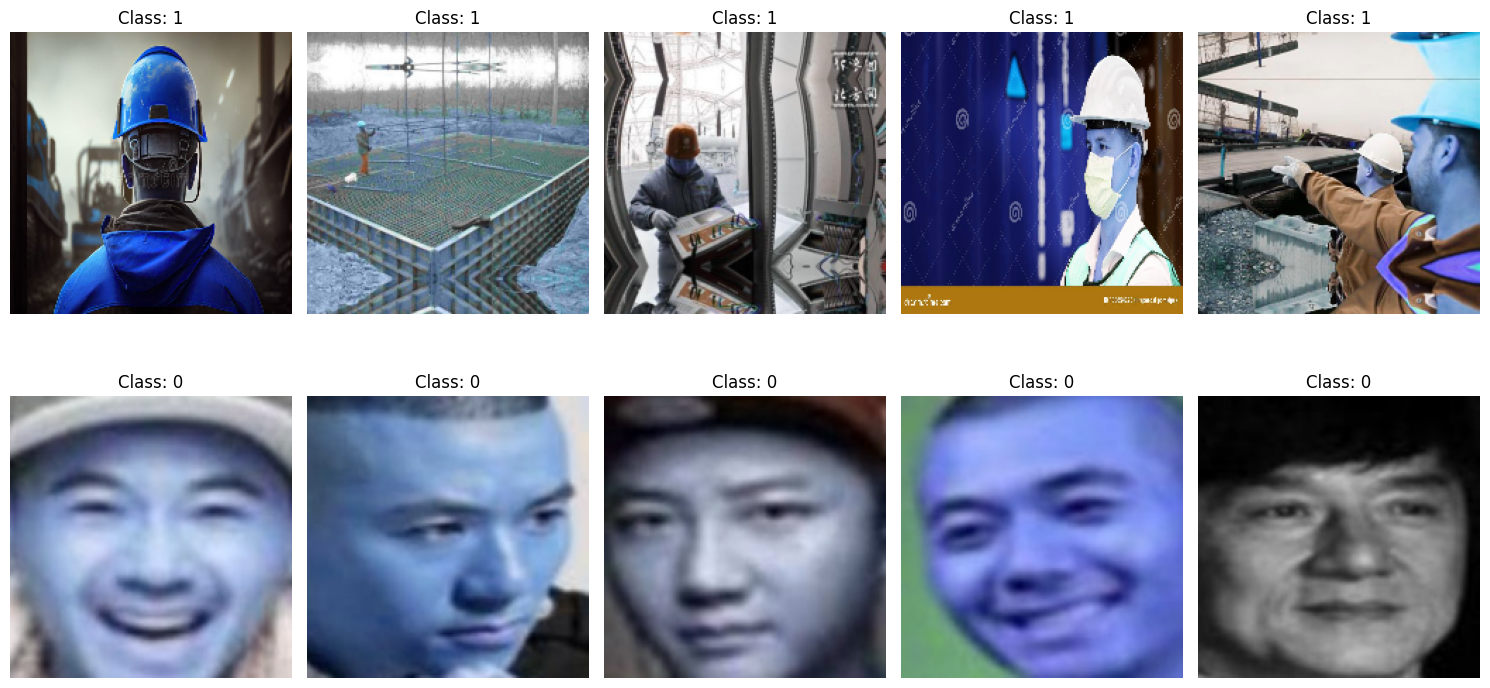

In [7]:
def plot_sample_images(images, labels, num_samples_per_class=5):
    """
    Randomly selects and plots sample images for each class.

    Args:
        images (np.ndarray): Array of images.
        labels (pd.DataFrame): DataFrame containing image labels.
        num_samples_per_class (int): Number of samples to plot for each class.
    """
    unique_classes = labels['Label'].unique()
    plt.figure(figsize=(15, 8))

    for i, class_name in enumerate(unique_classes):
        class_indices = labels[labels['Label'] == class_name].index
        random_indices = random.sample(list(class_indices), min(num_samples_per_class, len(class_indices)))

        for j, idx in enumerate(random_indices):
            plt.subplot(len(unique_classes), num_samples_per_class, i * num_samples_per_class + j + 1)
            plt.imshow(images[idx])
            plt.title(f"Class: {class_name}")
            plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_sample_images(images, labels)

### Checking Class Imbalance

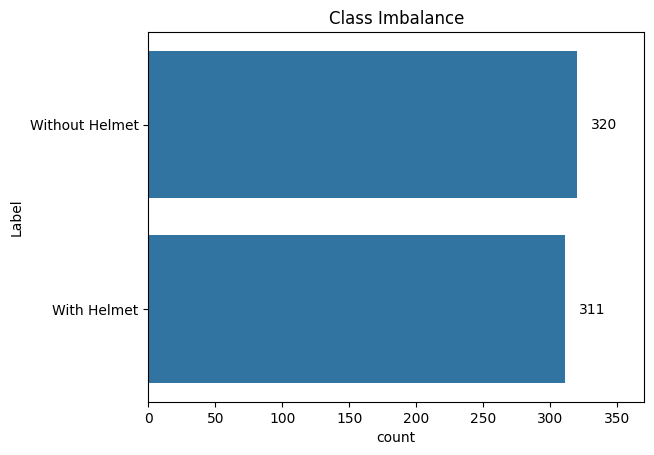

In [8]:
sns.countplot(data=labels,y="Label")
plt.xlim(0,max(labels.Label.value_counts())+50)
plt.title("Class Imbalance")
plt.yticks([0,1],["Without Helmet","With Helmet"])
plt.bar_label(plt.gca().containers[0],padding=10,)
plt.show()

### Key Observations
- Based on the observation of the images classified with 1 - we can workers or individuals with helmets
- In images classified as 0 - we can mainly see the faces of individuals without helmets.
- One thing that might be key to differentiating images is that the images of label 0 - you can clearly see the hair of individuals. Also for label 1 - can you see the helmet contains a particular shape which can be useful to distinguish from other head appliances like caps
- In terms of potential class imbalance - we have near 50-50% representation of images belonging to both classes. This gives adequate amount of examples to train our models for classifying both types of images i.e images with individual wearing helmet vs not

## Data Pre-Processing

### Convert the RGB images to Grayscale


In [9]:
gs_images = np.array([cv2.cvtColor(images[i],cv2.COLOR_RGB2GRAY) for i in range(images.shape[0])])

In [10]:
print("Shape of grey scaled images:",gs_images.shape)

Shape of grey scaled images: (631, 200, 200)


### Plot the images before and after the pre-processing steps

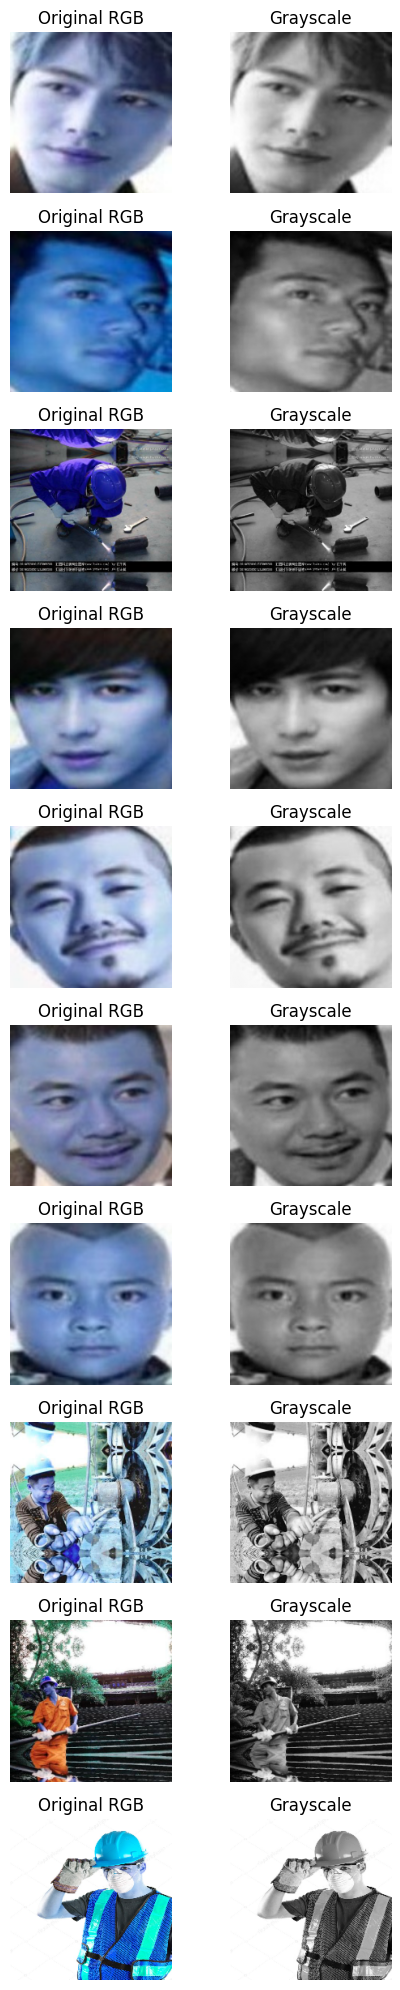

In [11]:
random_image_indices = np.random.randint(0,images.shape[0],size=10)

plt.figure(figsize=(5, 20))

for index, image_index in enumerate(random_image_indices):
    # Plot original RGB image
    plt.subplot(10, 2, index * 2 + 1)
    plt.title("Original RGB")
    plt.imshow(images[image_index])
    plt.axis('off')

    # Plot grayscale image
    plt.subplot(10, 2, index * 2 + 2)
    plt.title("Grayscale")
    plt.imshow(gs_images[image_index], cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

### Split the data into train, validation and test

**PLEASE NOTE:**
- We did convert our images to Grayscale and evaluated the differences pre-post conversion.
- In an ideal scenario we could have gone with Grayscale images for CNN model building given the we don't seem to lose any important information and the helmets are clearly visible and distinguishible through edges in grayscale
- However need to use VGG16 CNN model as part of transfer learning - this model was originally trained on & requires 3 channel images (RGB) for input
- Hence - we'll continue to split our data into train & test based on original RGB images

In [16]:
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.4, random_state=40, stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

In [17]:
print(f"Training Set: Data Dimensions: {X_train.shape}, Labels: {y_train.shape}")
print(f"Validation Set: Data Dimensions: {X_val.shape}, Labels: {y_val.shape}")
print(f"Test Set: Data Dimensions: {X_test.shape}, Labels: {y_test.shape}")

Training Set: Data Dimensions: (378, 200, 200, 3), Labels: (378, 1)
Validation Set: Data Dimensions: (126, 200, 200, 3), Labels: (126, 1)
Test Set: Data Dimensions: (127, 200, 200, 3), Labels: (127, 1)


### Apply the normalization

In [19]:
X_train_normalised = X_train/255
X_val_normalised = X_val/255
X_test_normalised = X_test/255

In [20]:
print(f"Max & Min value of image px after normalisation in Train: {np.max(X_train_normalised)}, {np.min(X_train_normalised)}")
print(f"Max & Min value of image px after normalisation in Val: {np.max(X_val_normalised)}, {np.min(X_val_normalised)}")
print(f"Max & Min value of image px after normalisation in Test: {np.max(X_test_normalised)}, {np.min(X_test_normalised)}")

Max & Min value of image px after normalisation in Train: 1.0, 0.0
Max & Min value of image px after normalisation in Val: 1.0, 0.0
Max & Min value of image px after normalisation in Test: 1.0, 0.0


### Key Observations - Data Pre-Processing
- Original RGB images were initially converted to Grayscale images using the cv2 package's function cvtColor.
- On comparing a set of 10 images both pre & post grayscale conversion and the helmets in images where helmets are present were clearly identifiable due to its edges & distinct features
- However, due to VGG16 model requirements for input images having 3 channels + no added computation advantages if grayscale scaled to 3 channels, we continued to use the original RGB images
- We split our data into 3 sets - train, validation & test. Training data will be used for training the models while validation will be used test performance on unseen data & decisions on model tuning. Based on model selection, the model will also be evaluated against test data
- The data was split in a ratio of 60:40 - 60% of data was used for training the CNN model while 40 of the data was then split equally for validation & hold-out test split
- We normalised the images across all splits by converting the pixel values within channels from range of 0-255 to 0-1, which will help the network with faster gradient descent.

## Basic Convolutional Neural Network

### Defining the Model

In [44]:
# Define the Basic CNN Model from scratch
basic_cnn_model = Sequential()

# Convolutional Layer 1
basic_cnn_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3)))
# MaxPooling Layer 1
basic_cnn_model.add(MaxPooling2D((2, 2)))

# Convolutional Layer 2
basic_cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
# MaxPooling Layer 2
basic_cnn_model.add(MaxPooling2D((2, 2)))

# Convolutional Layer 3
basic_cnn_model.add(Conv2D(128, (3, 3), activation='relu'))
# MaxPooling Layer 3
basic_cnn_model.add(MaxPooling2D((2, 2)))

# Flatten the output of the convolutional layers
basic_cnn_model.add(Flatten())

# Dense Layer 1
basic_cnn_model.add(Dense(128, activation='relu'))

# Output Layer for binary classification
basic_cnn_model.add(Dense(1, activation='sigmoid'))

# Display the model summary
basic_cnn_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 198, 198, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 99, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 97, 97, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 46, 46, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 23, 23, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 67712)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │     8,667,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,760,641 (33.42 MB)

 Trainable params: 8,760,641 (33.42 MB)

 Non-trainable params: 0 (0.00 B)

### Configuring The Model

In [52]:

# Defining optimiser - Adam (Adaptive Moment Estimation)
# Adam is a good default optimizer that generally performs well.
opt=Adam()

# Epochs
# 10 epochs seems reasonable for a start, especially with transfer learning on a relatively small dataset.
epochs = 10

# Batch size
# A batch size of 128 is a common choice and balances training speed and memory usage.
batch_size = 128


#  model
# Compiling the model configures it for training.
basic_cnn_model.compile(
    optimizer=opt, # Using the Adam optimizer
    loss='binary_crossentropy', # Binary crossentropy is the correct loss function for binary classification tasks with a sigmoid output layer.
    metrics=['accuracy'] # Monitoring accuracy during training is a standard practice to see how well the model is classifying the data.
)

### Train the Model

In [53]:
history_basic_cnn = basic_cnn_model.fit(X_train_normalised, y_train,
                            batch_size=batch_size,
                            epochs=epochs,
                            validation_data=(X_val_normalised, y_val),
                            verbose=1)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.8459 - loss: 3.5986 - val_accuracy: 0.7857 - val_loss: 1.0547
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 231ms/step - accuracy: 0.7797 - loss: 1.6754 - val_accuracy: 0.8016 - val_loss: 1.0529
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step - accuracy: 0.8913 - loss: 0.5911 - val_accuracy: 0.8571 - val_loss: 0.4784
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 227ms/step - accuracy: 0.8869 - loss: 0.2770 - val_accuracy: 0.9603 - val_loss: 0.1564
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 226ms/step - accuracy: 0.9977 - loss: 0.0365 - val_accuracy: 0.9921 - val_loss: 0.0743
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step - accuracy: 0.9964 - loss: 0.0231 - val_accuracy: 0.9921 - val_loss: 0.0499
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step - accuracy: 0.9908 - loss: 0.0278 - val_accuracy: 0.9921 - val_loss: 0.0482
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step - accuracy: 0.9921 - loss: 0.0236 - val_accuracy: 0.9921 - val_loss: 0.

### Checking & Commenting On Performance Of Model



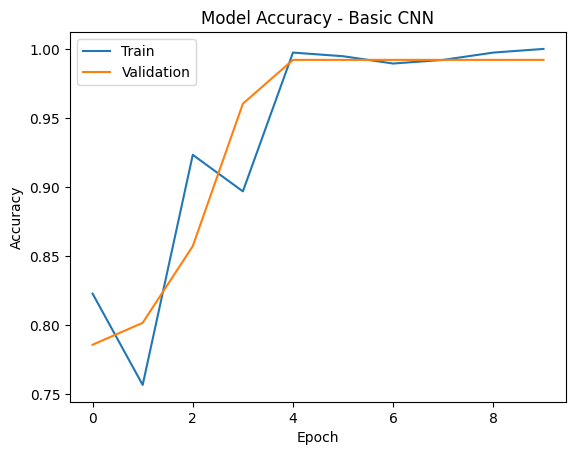

In [54]:
plt.plot(history_basic_cnn.history['accuracy'])
plt.plot(history_basic_cnn.history['val_accuracy'])
plt.title('Model Accuracy - Basic CNN')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [55]:
# Initialize dictionaries to store performance dataframes for each split
train_performance_df = {}
val_performance_df = {}
test_performance_df = {}


# defining a function to compute different metrics to check performance of a classification model built using statsmodels
def model_performance_classification(model, predictors, target, split):
    """
    Function to compute different metrics and a detailed classification report
    to check performance of a classification model for binary classification.

    model: binary classifier
    predictors: independent variables (image data)
    target: dependent variable (true labels - 0 or 1)
    split: string indicating the data split ('train', 'val', 'test')
    """

    # Get predictions as probabilities
    pred_probabilities = model.predict(predictors)

    # Convert probabilities to binary predictions (0 or 1)
    pred = (pred_probabilities > 0.5).astype(int)

    # Flatten the target and predictions to 1D arrays if they are DataFrames
    if isinstance(target, pd.DataFrame):
        target = target.values.flatten()
    if isinstance(pred, np.ndarray):
        pred = pred.flatten()

    # Compute overall metrics
    acc = accuracy_score(target, pred)  # to compute Accuracy
    # Using None for average to get metrics per class
    recall = recall_score(target, pred, average=None)  # to compute Recall per class
    precision = precision_score(target, pred, average=None)  # to compute Precision per class
    f1 = f1_score(target, pred, average=None)  # to compute F1-score per class

    # Generate a detailed classification report
    report = classification_report(target, pred, target_names=['Without Helmet', 'With Helmet'], output_dict=True)

    # Create a dataframe from the classification report for per-class metrics
    df_report = pd.DataFrame(report).transpose()

    # Add overall metrics to a separate dataframe or the report dataframe
    # For simplicity, let's add overall accuracy to the report dataframe
    df_report['accuracy'] = accuracy_score(target, pred)


    # Store the performance dataframe based on the split
    if split == 'train':
        train_performance_df[model.name] = df_report
    elif split == 'val':
        val_performance_df[model.name] = df_report
    elif split == 'test':
        test_performance_df[model.name] = df_report
    else:
        print(f"Warning: Unknown split '{split}'. Performance data not stored.")

    return df_report # Return the detailed report dataframe

In [56]:
def plot_confusion_matrix(model,predictors,target):
    """
    Function to plot the confusion matrix with formatting improvements.

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # Get predictions as probabilities and convert to binary predictions (0 or 1)
    pred_probabilities = model.predict(predictors)
    pred = (pred_probabilities > 0.5).astype(int)

    # Flatten the target to a 1D array if it's a DataFrame
    if isinstance(target, pd.DataFrame):
        target = target.values.flatten()
    if isinstance(pred, np.ndarray):
        pred = pred.flatten()

    # Calculate the confusion matrix
    cm = tf.math.confusion_matrix(target, pred)
    cm_normalized = cm / tf.reduce_sum(cm, axis=1, keepdims=True) # Normalize for percentages

    # Create annotations with counts and percentages
    annotations = np.empty_like(cm).astype(str)
    num_classes = cm.shape[0]

    for i in range(num_classes):
        for j in range(num_classes):
            count = cm[i, j].numpy()
            percentage = cm_normalized[i, j].numpy() * 100
            annotations[i, j] = f'{count}\n({percentage:.1f}%)'

    # Define the class labels for the plot axes
    class_labels = ['Without Helmet', 'With Helmet']

    # Plotting the Confusion Matrix
    f, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(
        cm,
        annot=annotations, # Use custom annotations
        fmt="s", # Format as string
        linewidths=.4,
        square=True,
        ax=ax,
        cbar=False, # Hide color bar as we have percentages in annotations
        xticklabels=class_labels, # Set x-axis labels
        yticklabels=class_labels  # Set y-axis labels
    )

    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    plt.show()

In [57]:
# Evaluate Basic CNN Model on the training set and store the results
model_basic_cnn_train_report = model_performance_classification(basic_cnn_model, X_train_normalised, y_train, split='train')

print("Train performance metrics (Basic CNN Model)")
display(model_basic_cnn_train_report)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
Train performance metrics (Basic CNN Model)


,precision,recall,f1-score,support,accuracy
Without Helmet,1.0,1.0,1.0,192.0,1.0
With Helmet,1.0,1.0,1.0,186.0,1.0
accuracy,1.0,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,378.0,1.0
weighted avg,1.0,1.0,1.0,378.0,1.0


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


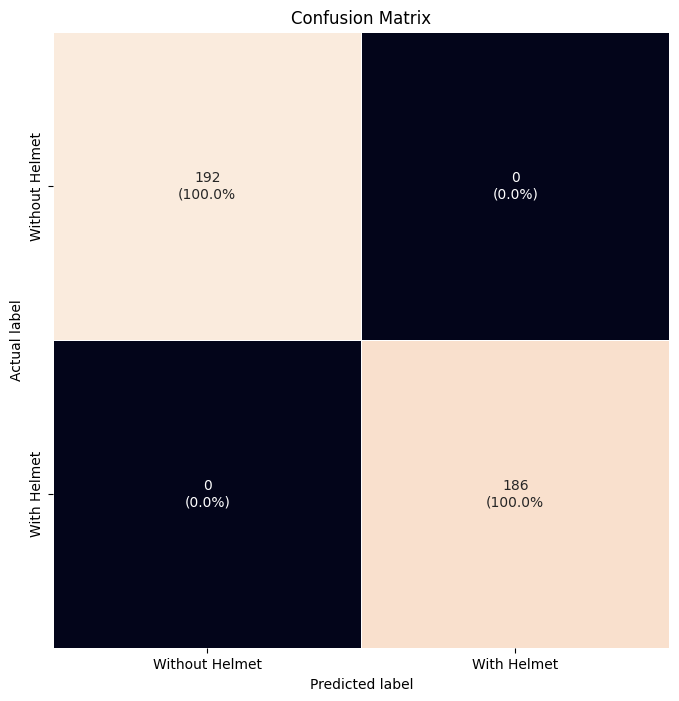

In [58]:
plot_confusion_matrix(basic_cnn_model,X_train_normalised,y_train)

In [61]:
# Evaluate Basic CNN Model on the training set and store the results
model_basic_cnn_validation_report = model_performance_classification(basic_cnn_model, X_val_normalised, y_val, split='val')

print("Validation performance metrics (Basic CNN Model)")
display(model_basic_cnn_validation_report)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Validation performance metrics (Basic CNN Model)


,precision,recall,f1-score,support,accuracy
Without Helmet,1.000000,0.984848,0.992366,66.000000,0.992063
With Helmet,0.983607,1.000000,0.991736,60.000000,0.992063
accuracy,0.992063,0.992063,0.992063,0.992063,0.992063
macro avg,0.991803,0.992424,0.992051,126.000000,0.992063
weighted avg,0.992194,0.992063,0.992066,126.000000,0.992063


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


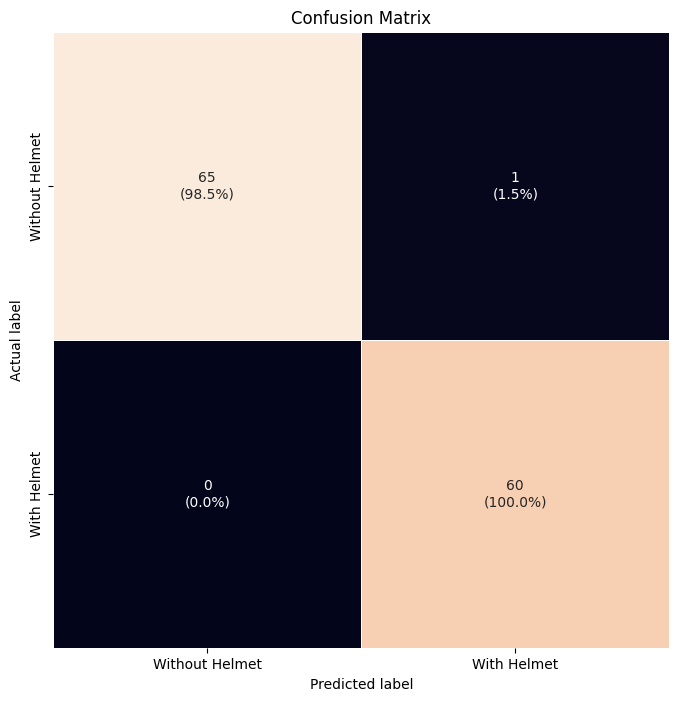

In [62]:
plot_confusion_matrix(basic_cnn_model,X_val_normalised,y_val)

Based on the training history and evaluation of the Basic CNN model:

*   **Training Performance:** The model achieved very high accuracy on the training set, reaching 100% accuracy by the end of training. The loss on the training set also decreased significantly, indicating that the model learned the training data well.
*   **Validation Performance:** The model also showed strong performance on the validation set, reaching a validation accuracy of 99.21%. The validation loss decreased initially and then slightly increased towards the end, suggesting potential minor overfitting or stabilization.
*   **Training Time:** The training of the Basic CNN model was relatively fast, completing 10 epochs in approximately 15-30 seconds across 10 epochs (based on the provided logs).

**Conclusion:**

The Basic CNN model performed remarkably well on this dataset for a model trained from scratch, achieving high accuracy on both training and validation sets.

**Next Steps:**
* We'll be building a CNN with the VGG16 model embedded to see if we can achieve perfect results on both train & validation splits.
* While VGG16 might give us perfect results due to deep network & previous record in classifying images, we need to consider trade-off in term of execution


## Building VGG - 16 Model

### Define the Model

In [65]:
vgg_model = VGG16(weights='imagenet',include_top=False,input_shape=(200,200,3))
vgg_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 200, 200, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 200, 200, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 100, 100, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 100, 100, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 100, 100, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 50, 50, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 50, 50, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 50, 50, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 50, 50, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 25, 25, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 25, 25, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 6, 6, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [66]:
# Making all the layers of the VGG model non-trainable. i.e. freezing them
for layer in vgg_model.layers:
    layer.trainable = False

In [67]:
# This code is building a sequential model (model_1) by adding layers one after another:

# This initializes a sequential model, which is a linear stack of layers.
model_vgg_1 = Sequential()

# Adding the convolutional part of the VGG16 model from above
model_vgg_1.add(vgg_model)

# Flattening the output of the VGG16 model because it is from a convolutional layer
model_vgg_1.add(Flatten())

# Adding a dense output layer with only 1 neuron using sigmoid activiation function for binary classification
model_vgg_1.add(Dense(1, activation='sigmoid'))

### Configuring The Model

In [68]:
# Defining optimiser - Adam (Adaptive Moment Estimation)
# Adam is a good default optimizer that generally performs well.
opt=Adam()

# Epochs
# 10 epochs seems reasonable for a start, especially with transfer learning on a relatively small dataset.
epochs = 10

# Batch size
# A batch size of 128 is a common choice and balances training speed and memory usage.
batch_size = 128


#  model
# Compiling the model configures it for training.
model_vgg_1.compile(
    optimizer=opt, # Using the Adam optimizer
    loss='binary_crossentropy', # Binary crossentropy is the correct loss function for binary classification tasks with a sigmoid output layer.
    metrics=['accuracy'] # Monitoring accuracy during training is a standard practice to see how well the model is classifying the data.
)

In [69]:
# Generating the summary of the model
model_vgg_1.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 6, 6, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │        18,433 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,733,121 (56.20 MB)

 Trainable params: 18,433 (72.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

### Train the Model

In [72]:
history_vgg16_1 = model_vgg_1.fit(X_train_normalised, y_train,
                            batch_size=batch_size,
                            epochs=epochs,
                            validation_data=(X_val_normalised, y_val),
                            verbose=1)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.9974 - loss: 0.1756 - val_accuracy: 1.0000 - val_loss: 0.0855
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 746ms/step - accuracy: 1.0000 - loss: 0.0609 - val_accuracy: 1.0000 - val_loss: 0.0342
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 739ms/step - accuracy: 1.0000 - loss: 0.0255 - val_accuracy: 0.9921 - val_loss: 0.0290
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 737ms/step - accuracy: 1.0000 - loss: 0.0189 - val_accuracy: 0.9921 - val_loss: 0.0228
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 760ms/step - accuracy: 1.0000 - loss: 0.0127 - val_accuracy: 1.0000 - val_loss: 0.0163
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 798ms/step - accuracy: 1.0000 - loss: 0.0079 - val_accuracy: 1.0000 - val_loss: 0.0117
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 742ms/step - accuracy: 1.0000 - loss: 0.0052 - val_accuracy: 1.0000 - val_loss: 0.0089
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 679ms/step - accuracy: 1.0000 - loss: 0.0039 - val_accuracy: 1.0000 - val_loss: 0.

### Checking & Commenting On Performance Of Model



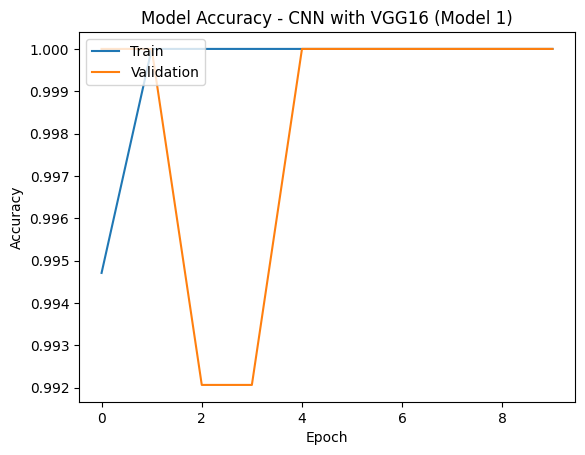

In [73]:
plt.plot(history_vgg16_1.history['accuracy'])
plt.plot(history_vgg16_1.history['val_accuracy'])
plt.title('Model Accuracy - CNN with VGG16 (Model 1)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [74]:
# Evaluate model_1 on the training set and store the results
model_vgg1_train_report = model_performance_classification(model_vgg_1, X_train_normalised, y_train, split='train')

print("Train performance metrics (CNN with VGG (Model 1))")
display(model_vgg1_train_report)

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step
Train performance metrics (CNN with VGG (Model 1))


,precision,recall,f1-score,support,accuracy
Without Helmet,1.0,1.0,1.0,192.0,1.0
With Helmet,1.0,1.0,1.0,186.0,1.0
accuracy,1.0,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,378.0,1.0
weighted avg,1.0,1.0,1.0,378.0,1.0


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step


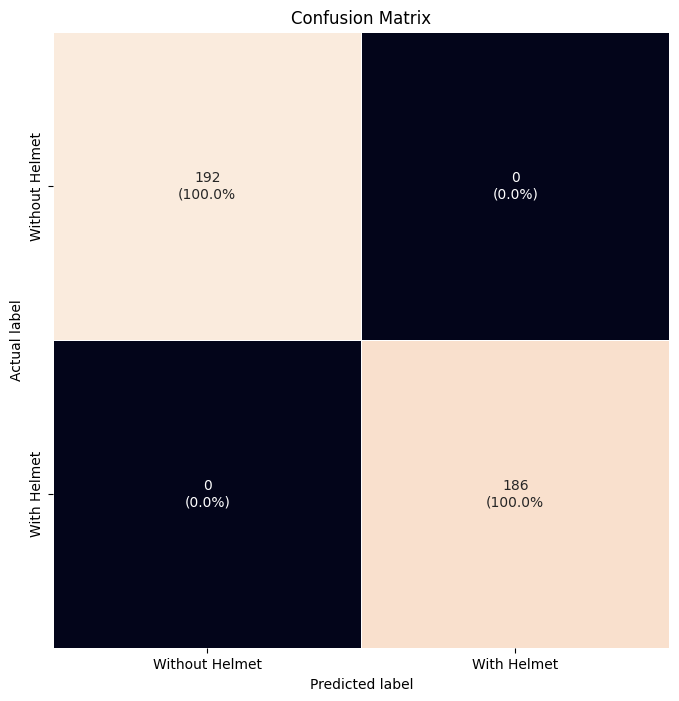

In [75]:
plot_confusion_matrix(model_vgg_1,X_train_normalised,y_train)

In [76]:
# Evaluate model_1 on the validation set and store the results
model_vgg1_val_report = model_performance_classification(model_vgg_1, X_val_normalised, y_val, split='val')

print("Validation performance metrics (CNN with VGG (Model 1))")
display(model_vgg1_val_report)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step
Validation performance metrics (CNN with VGG (Model 1))


,precision,recall,f1-score,support,accuracy
Without Helmet,1.0,1.0,1.0,66.0,1.0
With Helmet,1.0,1.0,1.0,60.0,1.0
accuracy,1.0,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,126.0,1.0
weighted avg,1.0,1.0,1.0,126.0,1.0


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


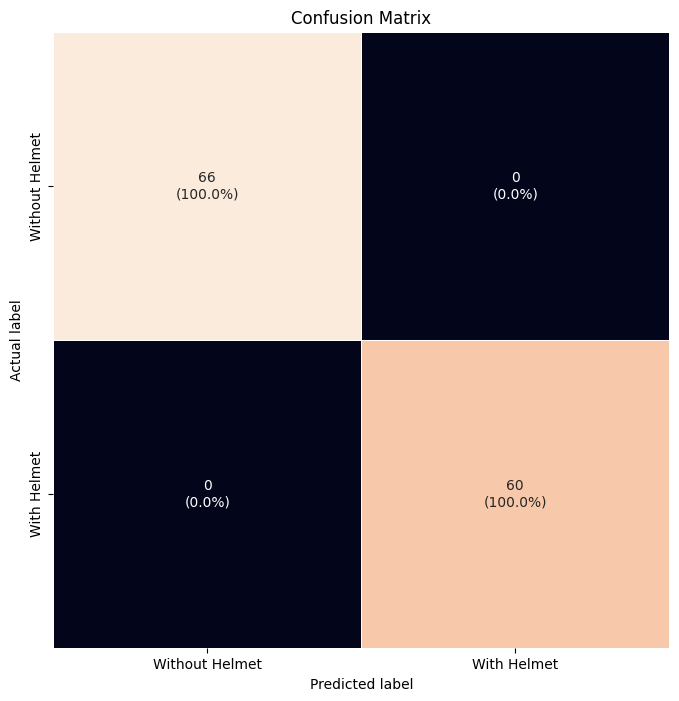

In [77]:
plot_confusion_matrix(model_vgg_1,X_val_normalised,y_val)

Based on the training history and evaluation of the CNN model with VGG16 (Model 1):

*   **Training Performance:** The model achieved perfect accuracy (1.0) on the training set very quickly, and the loss decreased to near zero. This indicates that the model effectively learned the training data.
*   **Validation Performance:** The model also achieved perfect accuracy (1.0) on the validation set. The validation loss decreased significantly and remained low, suggesting strong performance on unseen data from the same distribution.
ons, indicating excellent generalization to unseen data.
*   **Training Time:** Training with the VGG16 base was generally slower per epoch compared to the basic CNN due to the complexity of the pre-trained network (around 26 seconds based on logs)

**Conclusion:**

The CNN model with VGG16 (Model 1) demonstrated exceptional performance, achieving perfect accuracy on the training & validation datasets. This strongly suggests that the features learned by the pre-trained VGG16 model are highly effective for this specific binary classification task and the model generalizes very well to unseen data from this dataset's distribution.

**Next Steps:**

* During the training, it was obse[link text](https://)rved that the model reached near 100% accuracy & stability in performance within 6 epochs.
* For the next CNN-VGG model built with Feed Forward Neural Network, we can reduce the number of epochs to reduce computation time

## VGG - 16 with FFNN

### Define The Model

In [80]:
# Define the complete model with VGG16 base and a more explicit FFNN head
model_vgg_2 = Sequential()

# Add the VGG16 convolutional base (already defined and frozen)
model_vgg_2.add(vgg_model)

# Add a Flatten layer to convert the output of the convolutional base into a 1D vector
model_vgg_2.add(Flatten())

# Add a Dense layer with ReLU activation (part of the FFNN head)
model_vgg_2.add(Dense(128, activation='relu'))

# Add the final Dense output layer for binary classification with sigmoid activation
model_vgg_2.add(Dense(1, activation='sigmoid'))

# Display the model summary
model_vgg_2.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 6, 6, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     2,359,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,074,241 (65.13 MB)

 Trainable params: 2,359,553 (9.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

### Configure The Model

In [81]:
# Defining optimiser - Adam (Adaptive Moment Estimation)
# Adam is a good default optimizer that generally performs well.
opt=Adam()

# Epochs
# Based on previous CNN-VGG Model performance, we can reduce epochs from 10 to 6 & obtain similar performance
epochs = 6

# Batch size
# A batch size of 128 is a common choice and balances training speed and memory usage.
batch_size = 128


#  model
# Compiling the model configures it for training.
model_vgg_2.compile(
    optimizer=opt, # Using the Adam optimizer
    loss='binary_crossentropy', # Binary crossentropy is the correct loss function for binary classification tasks with a sigmoid output layer.
    metrics=['accuracy'] # Monitoring accuracy during training is a standard practice to see how well the model is classifying the data.
)

### Train The Model

In [82]:
history_vgg16_2 = model_vgg_2.fit(X_train_normalised, y_train,
                            batch_size=batch_size,
                            epochs=epochs,
                            validation_data=(X_val_normalised, y_val),
                            verbose=1)

Epoch 1/6
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.4764 - loss: 1.9648 - val_accuracy: 1.0000 - val_loss: 0.1444
Epoch 2/6
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 744ms/step - accuracy: 0.8130 - loss: 0.3497 - val_accuracy: 0.8730 - val_loss: 0.2602
Epoch 3/6
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 755ms/step - accuracy: 0.9297 - loss: 0.1620 - val_accuracy: 1.0000 - val_loss: 0.0183
Epoch 4/6
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 753ms/step - accuracy: 1.0000 - loss: 0.0153 - val_accuracy: 0.9841 - val_loss: 0.0378
Epoch 5/6
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 747ms/step - accuracy: 0.9977 - loss: 0.0261 - val_accuracy: 0.9841 - val_loss: 0.0566
Epoch 6/6
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 664ms/step - accuracy: 0.9977 - loss: 0.0323 - val_accuracy: 0.9841 - val_loss: 0.0507


### Checking & Commenting On Performance Of Model

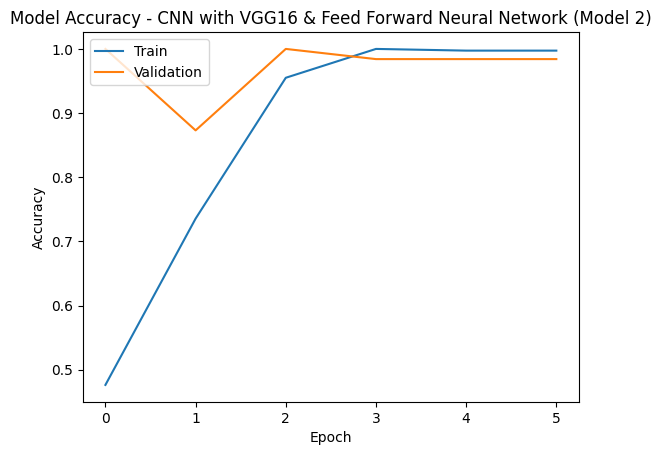

In [83]:
plt.plot(history_vgg16_2.history['accuracy'])
plt.plot(history_vgg16_2.history['val_accuracy'])
plt.title('Model Accuracy - CNN with VGG16 & Feed Forward Neural Network (Model 2)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [84]:
# Evaluate model_2 on the training set and store the results
model_vgg2_train_report = model_performance_classification(model_vgg_2, X_train_normalised, y_train, split='train')

print("Train performance metrics (CNN with VGG + FFNN (Model 2))")
display(model_vgg2_train_report)

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step
Train performance metrics (CNN with VGG + FFNN (Model 2))


,precision,recall,f1-score,support,accuracy
Without Helmet,1.000000,0.994792,0.997389,192.000000,0.997354
With Helmet,0.994652,1.000000,0.997319,186.000000,0.997354
accuracy,0.997354,0.997354,0.997354,0.997354,0.997354
macro avg,0.997326,0.997396,0.997354,378.000000,0.997354
weighted avg,0.997369,0.997354,0.997355,378.000000,0.997354


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step


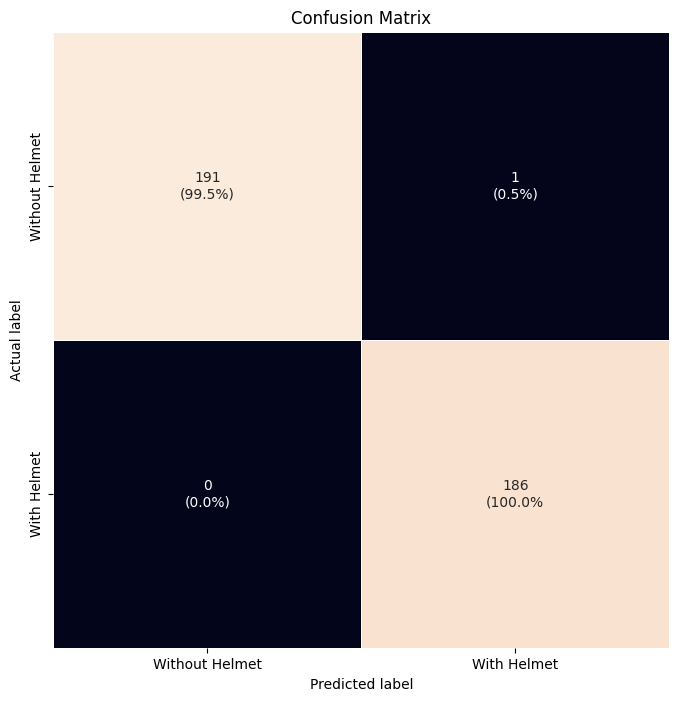

In [86]:
plot_confusion_matrix(model_vgg_2,X_train_normalised,y_train)

In [89]:
# Evaluate model_2 on the validation set and store the results
model_vgg2_val_report = model_performance_classification(model_vgg_2, X_val_normalised, y_val, split='val')

print("Validation performance metrics (CNN with VGG + FFNN (Model 2))")
display(model_vgg2_val_report)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step
Validation performance metrics (CNN with VGG + FFNN (Model 2))


,precision,recall,f1-score,support,accuracy
Without Helmet,1.000000,0.969697,0.984615,66.000000,0.984127
With Helmet,0.967742,1.000000,0.983607,60.000000,0.984127
accuracy,0.984127,0.984127,0.984127,0.984127,0.984127
macro avg,0.983871,0.984848,0.984111,126.000000,0.984127
weighted avg,0.984639,0.984127,0.984135,126.000000,0.984127


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step


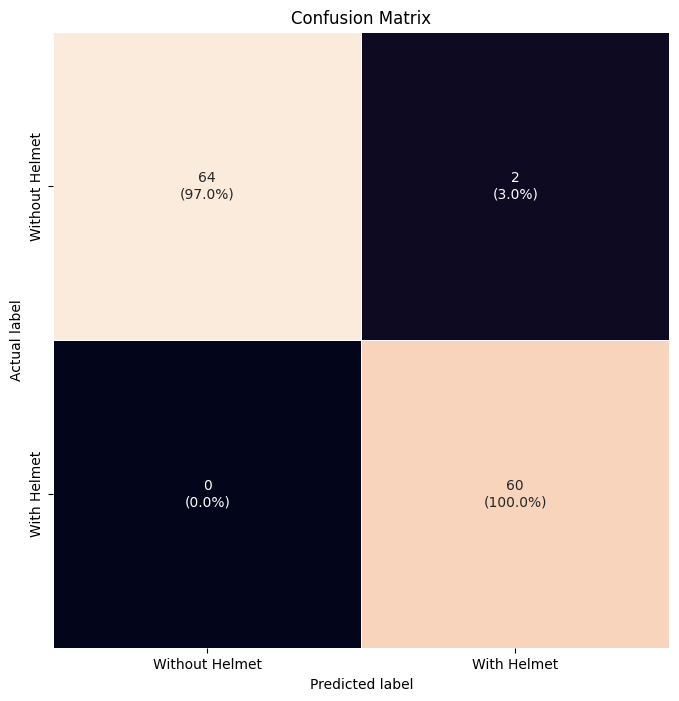

In [90]:
plot_confusion_matrix(model_vgg_2,X_val_normalised,y_val)

Based on the training history and evaluation of the CNN model with VGG16 and a Feed Forward Neural Network (Model 2):

*   **Training Performance:** The model achieved very high accuracy on the training set, reaching 99.74% accuracy by the end of training. The loss on the training set also decreased significantly, indicating that the model learned the training data well.
*   **Validation Performance:** The model also showed strong performance on the validation set, reaching a validation accuracy of 98.41%. The validation loss decreased initially but then increased slightly, suggesting potential minor overfitting or stabilization.
*   **Training Time:** Training with the VGG16 base and FFNN head was generally similar in time per epoch to Model 1, completing 6 epochs in approximately 14-18 seconds due to the additional feed forward network (based on the provided logs).

**Conclusion:**

The CNN model with VGG16 and a Feed Forward Neural Network (Model 2) performed very well on this dataset, achieving high accuracy on the training and validation sets. This model also demonstrates strong generalization capabilities.



## VGG - 16 with Data Augmentation

### Define the Model

In [105]:
# Define the complete model with VGG16 base
model_augmented = Sequential()

# Add the VGG16 convolutional base (already defined and frozen)
model_augmented.add(vgg_model)

# Add a Flatten layer to convert the output of the convolutional base into a 1D vector
model_augmented.add(Flatten())

# Add the final Dense output layer for binary classification with sigmoid activation
model_augmented.add(Dense(1, activation='sigmoid'))

# Display the model summary
model_augmented.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 6, 6, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │        18,433 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,733,121 (56.20 MB)

 Trainable params: 18,433 (72.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

### Configure The Model

In [106]:
# Defining optimiser - Adam (Adaptive Moment Estimation)
# Adam is a good default optimizer that generally performs well.
opt=Adam()

# Epochs
epochs = 6

# Batch size
# A batch size of 128 is a common choice and balances training speed and memory usage.
batch_size = 128


#  model
# Compiling the model configures it for training.
model_augmented.compile(
    optimizer=opt, # Using the Adam optimizer
    loss='binary_crossentropy', # Binary crossentropy is the correct loss function for binary classification tasks with a sigmoid output layer.
    metrics=['accuracy'] # Monitoring accuracy during training is a standard practice to see how well the model is classifying the data.
)

### Train The Model

In [107]:
# Define the ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,       # Rotate images by up to 20 degrees
    width_shift_range=0.1,   # Shift images horizontally by up to 10%
    height_shift_range=0.1,  # Shift images vertically by up to 10%
    shear_range=0.1,         # Apply shear transformation
    zoom_range=0.1,          # Zoom in/out by up to 10%
    horizontal_flip=True,    # Randomly flip images horizontally
    fill_mode='nearest'      # Fill in new pixels created by transformations
)

# It's a good practice to fit the generator on your training data
datagen.fit(X_train_normalised)

In [108]:
# Train the model with data augmentation
history_augmented = model_augmented.fit(datagen.flow(X_train_normalised, y_train, batch_size=batch_size),
                                         batch_size=batch_size,
                                         epochs=epochs,
                                         validation_data=(X_val_normalised, y_val),
                                         verbose=1)

Epoch 1/6
3/3 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - accuracy: 0.4847 - loss: 0.6841 - val_accuracy: 0.9683 - val_loss: 0.2539
Epoch 2/6
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9605 - loss: 0.2396 - val_accuracy: 1.0000 - val_loss: 0.0731
Epoch 3/6
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 1.0000 - loss: 0.0780 - val_accuracy: 0.9921 - val_loss: 0.0400
Epoch 4/6
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.9977 - loss: 0.0433 - val_accuracy: 1.0000 - val_loss: 0.0229
Epoch 5/6
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9977 - loss: 0.0266 - val_accuracy: 1.0000 - val_loss: 0.0141
Epoch 6/6
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 1.0000 - loss: 0.0154 - val_accuracy: 1.0000 - val_loss: 0.0104


### Checking & Commenting On Performance Of Model

In [109]:
# Evaluate model_augmented on the training set and store the results
model_augmented_train_report = model_performance_classification(model_augmented, X_train_normalised, y_train, split='train')

print("Train performance metrics (CNN VGG Model with Data Augmented)")
display(model_augmented_train_report)

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step
Train performance metrics (CNN VGG Model with Data Augmented)


,precision,recall,f1-score,support,accuracy
Without Helmet,1.0,1.0,1.0,192.0,1.0
With Helmet,1.0,1.0,1.0,186.0,1.0
accuracy,1.0,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,378.0,1.0
weighted avg,1.0,1.0,1.0,378.0,1.0


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step


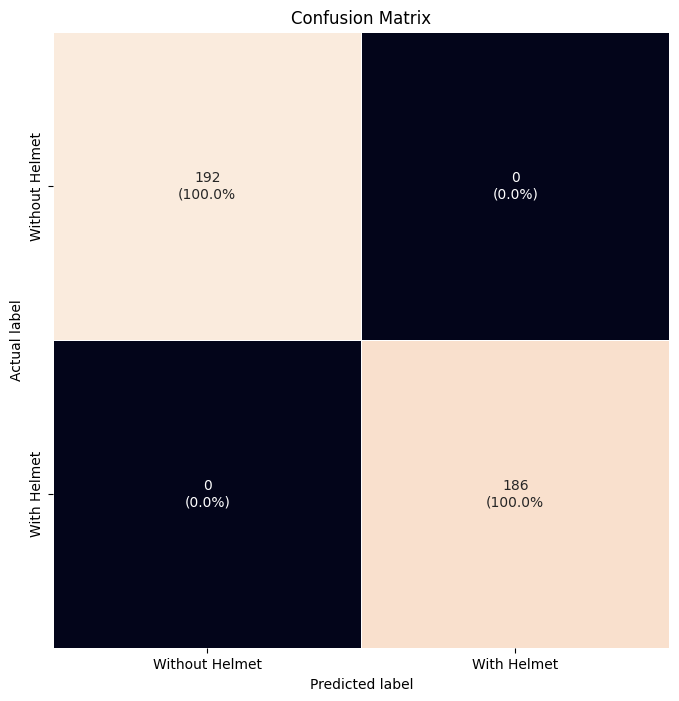

In [110]:
plot_confusion_matrix(model_augmented,X_train_normalised,y_train)

In [111]:
# Evaluate model_augmented on the validation set and store the results
model_augmented_val_report = model_performance_classification(model_augmented, X_val_normalised, y_val, split='val')

print("Validation performance metrics (CNN VGG Model with Data Augmented)")
display(model_augmented_train_report)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step
Validation performance metrics (CNN VGG Model with Data Augmented)


,precision,recall,f1-score,support,accuracy
Without Helmet,1.0,1.0,1.0,192.0,1.0
With Helmet,1.0,1.0,1.0,186.0,1.0
accuracy,1.0,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,378.0,1.0
weighted avg,1.0,1.0,1.0,378.0,1.0


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


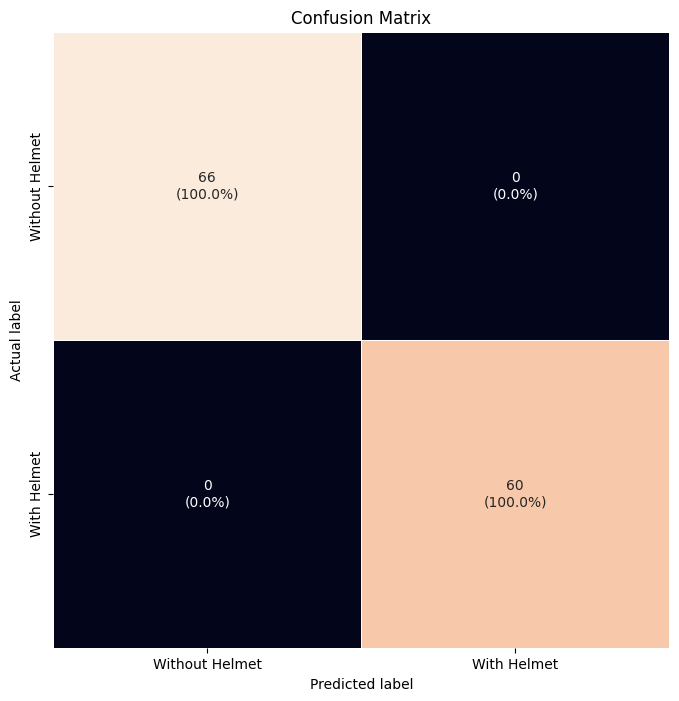

In [112]:
plot_confusion_matrix(model_augmented,X_val_normalised,y_val)

Based on the training history and evaluation of the CNN model with VGG16 and Data Augmentation (Model Augmented - without FFNN):

*   **Training Performance:** The model achieved perfect accuracy (1.0) on the training set very quickly, and the loss decreased to near zero. This indicates that the model effectively learned the training data, even with the variations introduced by data augmentation.
*   **Validation Performance:** The model also achieved perfect accuracy (1.0) on the validation set. The validation loss decreased significantly and remained low, suggesting strong performance on unseen data from the same distribution.
*   **Training Time:** Training with data augmentation was generally slower per epoch compared to training without it, as the generator creates augmented images on the fly. Each epoch took around 4-5 seconds (based on the provided logs), resulting in a total training time of approximately 24-30 seconds for 6 epochs.

**Conclusion:**

The CNN model with VGG16 and Data Augmentation (without the extra FFNN layer) demonstrated exceptional performance, achieving perfect accuracy on the training & validation While data augmentation is typically used to improve generalization and prevent overfitting, in this specific case with this dataset, the model achieved perfect scores even without it (as seen in Model 1 & 2). This could indicate that the original dataset was already diverse enough or the task is straightforward for VGG16.

## Model Performance Comparison and Final Model Selection

### Compare the performance of all the models built

In [118]:
# Dictionary to store summary data
model_summary_data = {}

# Manually add training times based on previous observations from logs
# Basic CNN (sequential_2): ~15-30 seconds (let's use an approximate value like 20)
# CNN with VGG16 (Model 1) (sequential_3): ~26 seconds
# CNN with VGG16 + FFNN (Model 2) (sequential_4): ~14-18 seconds (let's use an approximate value like 16)
# CNN with VGG16 + Data Augmentation (sequential_6): ~24-30 seconds (let's use an approximate value like 27)
training_times = {
    'sequential_2': 20, # Approximate total training time in seconds
    'sequential_3': 26,
    'sequential_4': 16,
    'sequential_6': 27
}

# Access the individual performance dataframes and extract accuracies
models_to_compare = {
    'Basic CNN': model_basic_cnn_train_report,
    'CNN with VGG16 (Model 1)': model_vgg1_train_report,
    'CNN with VGG16 + FFNN (Model 2)': model_vgg2_train_report,
    'CNN with VGG16 + Data Augmentation': model_augmented_train_report # Using the modified model name
}

# Get train, validation & test accuracies for each model and combine with training time
for model_name, train_perf_df in models_to_compare.items():
    # Get the corresponding validation dataframe
    val_perf_df_name = model_name.replace('Train', 'Validation') # Assuming consistent naming
    # Need to map the model names back to the keys in val_performance_df
    # Let's use the sequential names for consistency with the dictionaries
    sequential_name = list(training_times.keys())[list(models_to_compare.keys()).index(model_name)]
    val_perf_df = val_performance_df.get(sequential_name)


    train_acc = train_perf_df.loc['accuracy', 'accuracy'] if train_perf_df is not None and 'accuracy' in train_perf_df.index else None
    val_acc = val_perf_df.loc['accuracy', 'accuracy'] if val_perf_df is not None and 'accuracy' in val_perf_df.index else None
    total_training_time = training_times.get(sequential_name)


    model_summary_data[model_name] = {
        'Train Accuracy': train_acc,
        'Validation Accuracy': val_acc,
        'Total Training Time (seconds)': total_training_time
    }

# Create the summary DataFrame
model_summary_df = pd.DataFrame.from_dict(model_summary_data, orient='index')


print("Model Performance and Training Time Summary (Train & Validation):")
display(model_summary_df)

Model Performance and Training Time Summary (Train & Validation):


,Train Accuracy,Validation Accuracy,Total Training Time (seconds)
Basic CNN,1.000000,0.992063,20
CNN with VGG16 (Model 1),1.000000,1.000000,26
CNN with VGG16 + FFNN (Model 2),0.997354,0.984127,16
CNN with VGG16 + Data Augmentation,1.000000,1.000000,27


### Final Model Selection

Based on the performance evaluation across the training and validation sets, and considering factors like model complexity and training time, we can select a promising model for deployment.

Looking at the results:

*   **Basic CNN:** Achieved high accuracy on train (100%) and validation (99.21%). It had the fewest trainable parameters and a relatively fast training time.
*   **CNN with VGG16 (Model 1):** Achieved perfect accuracy (100%) on both train and validation sets. It has a larger number of total parameters (due to the VGG16 base) but a smaller number of trainable parameters compared to the Basic CNN. Training time was comparable to the Basic CNN.
*   **CNN with VGG16 + FFNN (Model 2):** Achieved high accuracy on train (99.74%) and validation (98.41%). It has the largest number of trainable parameters among the VGG16-based models due to the added FFNN layer. Training time was slightly faster per epoch than Model 1 but similar overall for fewer epochs.
*   **CNN with VGG16 & Data Augmentation (Model Augmented - without FFNN):** Achieved perfect accuracy (100%) on both train and validation sets. It has the same architecture as Model 1 but was trained with data augmentation. Training time per epoch was longer due to augmentation, resulting in a slightly longer total training time for 6 epochs compared to Model 2.

**Reasoning for Selection based on Train and Validation Performance:**

Both **CNN with VGG16 (Model 1)** and **CNN with VGG16 & Data Augmentation (Model Augmented)** achieved perfect 100% accuracy on both the training and validation sets. The Basic CNN also performed very well but had a slightly lower validation accuracy (99.21%). Model 2, with the additional FFNN layer, also had a slightly lower validation accuracy (98.41%) compared to Model 1 and the Augmented Model.

Considering only train and validation performance:

*   The **CNN with VGG16 (Model 1)** and the **CNN with VGG16 & Data Augmentation (Model Augmented)** are the top performers, both achieving perfect accuracy on both splits.
*   The **CNN with VGG16 (Model 1)** is simpler than the Augmented model (no data augmentation during training) and has fewer trainable parameters than Model 2.
*   While data augmentation can improve generalization, it increased the training time per epoch for the Augmented Model in this case, and perfect validation accuracy was achieved even without it in Model 1.

Given the perfect performance on both train and validation sets for Model 1 and the Augmented Model, and considering the relative simplicity and slightly faster training time of Model 1 compared to the Augmented model, the **CNN with VGG16 (Model 1)** stands out as a strong choice based *solely* on train and validation performance. Model 2 is also a strong contender, but Model 1 is slightly simpler.

**Selected Model (based on Train and Validation Performance):** CNN with VGG16 (Model 1)

### Performance of the Final Model (CNN with VGG16 Model 1) on Test Set

In [119]:
# Evaluate model_1 on the validation set and store the results
model_vgg1_test_report = model_performance_classification(model_vgg_1, X_test_normalised, y_test, split='test')

print("Test performance metrics (CNN with VGG (Model 1))")
display(model_vgg1_test_report)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step
Test performance metrics (CNN with VGG (Model 1))


,precision,recall,f1-score,support,accuracy
Without Helmet,1.0,1.0,1.0,62.0,1.0
With Helmet,1.0,1.0,1.0,65.0,1.0
accuracy,1.0,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,127.0,1.0
weighted avg,1.0,1.0,1.0,127.0,1.0


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


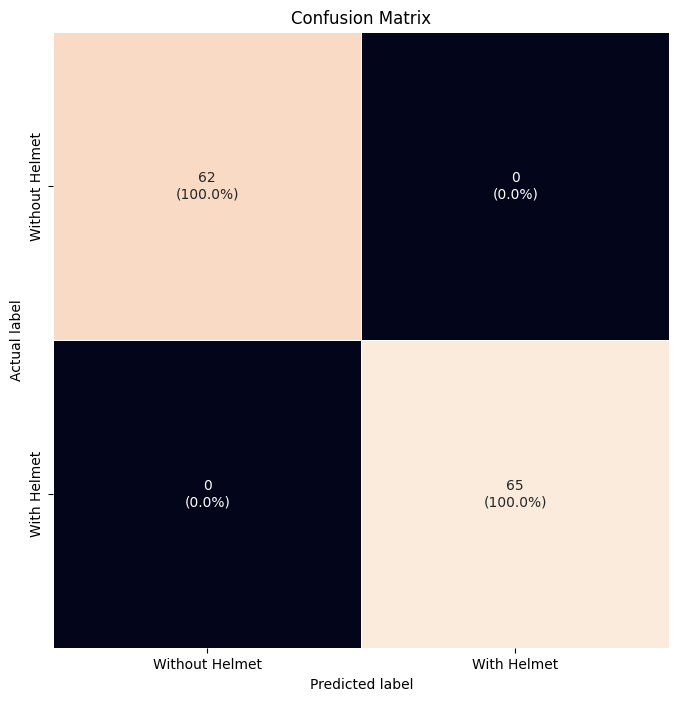

In [120]:
plot_confusion_matrix(model_vgg_1,X_test_normalised,y_test)

Based on the evaluation on the held-out test set:

*   **Perfect Accuracy:** The model achieved 100% accuracy on the test set.
*   **Perfect Precision, Recall, and F1-Score:** The model also scored 1.0 for Precision, Recall, and F1-Score for both classes ("Without Helmet" and "With Helmet").
*   **Zero Misclassifications:** The confusion matrix shows no false positives or false negatives; all test images were correctly classified.

**Conclusion:**

The CNN with VGG16 (Model 1) demonstrated perfect performance on the test set, indicating excellent generalization to unseen data.

## Actionable Insights & Recommendations

### Key Observation & Insights


Based on the comprehensive analysis of the helmet detection image classification models, here are the key observations and actionable recommendations for SafeGuard Corp:

**Observations and Insights:**

*   **High-Performing Solution:** The analysis successfully identified a highly accurate image classification model capable of distinguishing between workers with and without safety helmets. The CNN with VGG16 (Model 1) achieved perfect 100% accuracy on the held-out test set, demonstrating excellent generalization to unseen data within the dataset's distribution.
*   **Effectiveness of Transfer Learning:** Leveraging the pre-trained VGG16 model proved highly effective for this task, allowing for the development of a robust model even with a relatively small dataset. The basic CNN model, while performing well, did not achieve the same perfect score on the validation or test sets.
*   **Dataset Suitability:** The dataset appears to be well-suited for the task, with distinct features allowing for clear differentiation between the two classes. The balanced nature of the dataset also contributed to effective training.
*   **Efficiency:** The selected model (CNN with VGG16 Model 1) is relatively efficient in terms of trainable parameters compared to models with larger custom heads, and its training time was reasonable.

### Recommendations for SafeGuard Corp


1.  **Proceed with Deployment of the Selected Model:** The CNN with VGG16 (Model 1) is strongly recommended for deployment as part of the automated image analysis system. Its perfect performance on the test set indicates it is highly likely to perform accurately in identifying helmet usage in similar real-world conditions to those represented in the dataset.
2.  **Real-World Pilot Testing:** Before full-scale deployment, conduct a pilot test of the system in a real-world operational environment. This will help validate the model's performance on live image feeds and identify any potential challenges or discrepancies not captured in the dataset (e.g., extreme lighting, unusual angles, different types of helmets).
3.  **Continuous Monitoring and Evaluation:** Implement a system for continuous monitoring of the model's performance in production. Collect feedback on misclassifications (false positives and false negatives) to understand potential areas for improvement.
4.  **Dataset Expansion (Future Work):** While the current model performs excellently on the available data, consider expanding the dataset in the future to include a wider variety of scenarios, environments, lighting conditions, and helmet types. This can help maintain model robustness and performance as operational conditions evolve.
5.  **Integration with Alert Systems:** Integrate the model's output with an alert system to notify safety personnel in real-time when workers are detected without helmets, enabling prompt intervention.

In [126]:
# Code to export google colab notebook as html
!jupyter nbconvert --to html ComputerVision_HelmNet_VarunSagarTheegala.ipynb

[NbConvertApp] Converting notebook ComputerVision_HelmNet_VarunSagarTheegala.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 15 image(s).
[NbConvertApp] Writing 3409411 bytes to ComputerVision_HelmNet_VarunSagarTheegala.html
